In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [13]:
dir_path = "C:/Users/alibh/OneDrive/Desktop/Enterprise_project/data_dir"

In [14]:
target_size = (224, 224)
waste_labels = {"Fresh_Apple":0, "Rotten_Apple":1}

In [15]:
def load_dataset(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
  x, labels = shuffle(x, labels, random_state=42)
  input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
  print("X shape: ", np.array(x).shape)
  print(f"Number of Labels: {len(np.unique(labels))} , Number of Observation: {len(labels)}")
  print("Input Shape: ", input_shape)
  return x, labels, input_shape

In [16]:
x, labels, input_shape = load_dataset(dir_path)

X shape:  (5074, 224, 224, 3)
Number of Labels: 2 , Number of Observation: 5074
Input Shape:  (224, 224, 3)


In [17]:
def visualizeation_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

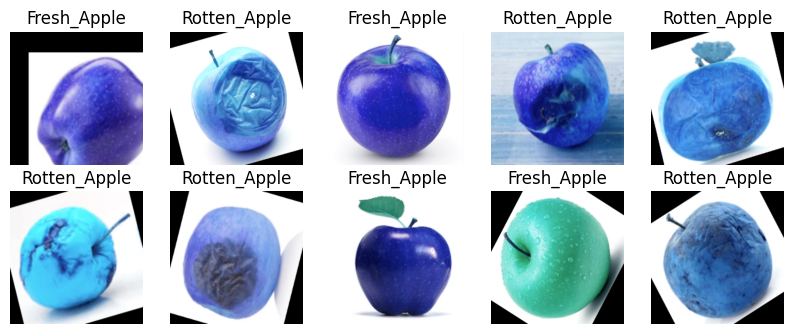

In [7]:
visualizeation_img(x, labels, 10)

In [18]:
def CNN_data_preparation():
  train = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
  test = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  train_generator = train.flow_from_directory(directory=dir_path,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  test_generator = test.flow_from_directory(directory=dir_path,
                                            target_size=(target_size),
                                            batch_size=251,
                                            class_mode="categorical",
                                            subset="validation")
  return train_generator, test_generator

In [19]:
train_generator, test_generator = CNN_data_preparation()

Found 4567 images belonging to 2 classes.
Found 507 images belonging to 2 classes.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

def CNN_create_and_fit_model(train_generator, test_generator, input_shape, num_classes, summary=True, fit=True, epochs=100):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=input_shape, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(Flatten())

    model.add(Dense(units=64, activation="relu"))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=num_classes, activation="softmax"))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

    callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
                 ModelCheckpoint(filepath="new_model.keras", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
    
    if summary:
        model.summary()
    
    if fit:
        history = model.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                            callbacks=callbacks, steps_per_epoch=10, validation_steps=251//32)

        return model, history

    return model

In [22]:
# Usage
num_classes = 2 # Set this to the correct number of classes in your dataset
model, history = CNN_create_and_fit_model(train_generator, test_generator, input_shape=(224, 224, 3), num_classes=num_classes)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,698 (6.28 MB)

 Trainable params: 1,645,698 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5236 - loss: 0.8226 - precision_1: 0.5236 - recall_1: 0.5236
Epoch 1: val_loss improved from inf to 0.67983, saving model to new_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5219 - loss: 0.8176 - precision_1: 0.5219 - recall_1: 0.5219 - val_accuracy: 0.5819 - val_loss: 0.6798 - val_precision_1: 0.5819 - val_recall_1: 0.5819
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5462 - loss: 0.6869 - precision_1: 0.5462 - recall_1: 0.5462
Epoch 2: val_loss did not improve from 0.67983
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5462 - loss: 0.6871 - precision_1: 0.5462 - recall_1: 0.5462 - val_accuracy: 0.5819 - val_loss: 0.6823 - val_precision_1: 0.5819 - val_recall_1: 0.5819
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.6143 - loss: 0.6781 - precision_1: 0.6143 - recall_1: 0.6143
Epoch 3: val_loss did not improve from 0.67983
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step

In [23]:
model.save('C:/Users/alibh/OneDrive/Desktop/Enterprise_project/apple_model.keras')

In [ ]:
def CNN_model_evaluate(model, test_generator, history):
    # Evaluate the model
    loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
    print("Test Accuracy: %.2f" % (100 * acc))
    print("Test Loss: %.2f" % (100 * loss))
    print("Test Precision: %.2f" % (100 * precision))
    print("Test Recall: %.2f" % (100 * recall))

    # Get the test data and predictions
    X_test, y_test = next(test_generator)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    target_names = list(waste_labels.keys())
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Plot training & validation accuracy and loss
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], color="r", label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], color="b", label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.ylim([min(plt.ylim()), 1])
    plt.title("Training and Validation Accuracy", fontsize=16)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(plt.ylim())])
    plt.title("Training and Validation Loss", fontsize=16)

    plt.show()

    return y_test, y_pred

# Call the evaluation function
y_test, y_pred = CNN_model_evaluate(model, test_generator, history)


In [ ]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  
  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Labels", fontweight="bold")
  plt.xlabel("Predicted Labels", fontweight="bold")

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys())

In [48]:
def CNN_model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [ ]:
# Load the pre-trained model
model_path = "C:/Users/alibh/OneDrive/Desktop/Enterprise_project/apple_model.keras"
model = load_model(model_path)

def CNN_model_testing(path, target_size=(224, 224)):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, *target_size, 3))
    predicted_class = np.argmax(p[0])
    return img, p, predicted_class

def plot_model_testing(img, p, predicted_class):
    plt.axis("off")
    plt.imshow(img.squeeze())
    plt.title(f"Maximum Probability: {np.max(p[0]):.2f}\nPredicted Class: {reverse_waste_labels[predicted_class]}")
    plt.show()

# Test the functions
img_path = "C:/Users/alibh/OneDrive/Desktop/test/images.jpeg"
img, p, predicted_class = CNN_model_testing(img_path)
plot_model_testing(img, p, predicted_class)

In [ ]:
img, p, predicted_class = CNN_model_testing("C:/Users/alibh/OneDrive/Desktop/test/images.jpeg")

In [ ]:
# Define the waste labels and create a reverse mapping
waste_labels = {"Fresh_Apple": 0, "Rotten_Apple": 1}
reverse_waste_labels = {v: k for k, v in waste_labels.items()}

def CNN_model_testing(path):
    img = image.load_img(path, target_size=(224, 224))  # Ensure target_size matches your model's input
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])
    return img, p, predicted_class

def plot_model_testing(img, p, predicted_class):
    plt.axis("off")
    plt.imshow(img.squeeze())
    plt.title("Maximum Probability: " + str(np.max(p[0], axis=-1)) + "\n" + "Predicted Class: " + str(reverse_waste_labels[predicted_class]))
    plt.show()

# Test the functions
img, p, predicted_class = CNN_model_testing("C:/Users/alibh/OneDrive/Desktop/test/images.jpeg")
plot_model_testing(img, p, predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


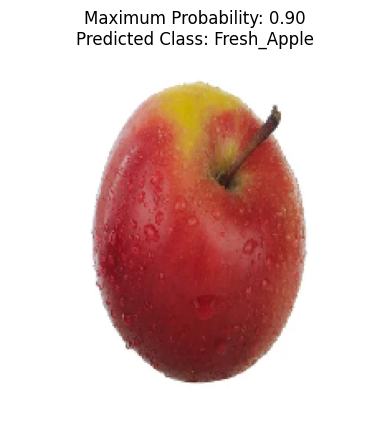

In [72]:
#.........................
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

# Define the waste labels and create a reverse mapping
waste_labels = {"Fresh_Apple": 0, "Rotten_Apple": 1}
reverse_waste_labels = {v: k for k, v in waste_labels.items()}

# Load the pre-trained model
model = load_model("C:/Users/alibh/OneDrive/Desktop/Enterprise_project/cnn_model.keras")  # Replace with the actual path to your model

def CNN_model_testing(path):
    img = image.load_img(path, target_size=(224, 224))  # Ensure target_size matches your model's input
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])
    return img, p, predicted_class

def plot_model_testing(img, p, predicted_class):
    plt.axis("off")
    plt.imshow(img.squeeze())
    plt.title(f"Maximum Probability: {np.max(p[0]):.2f}\nPredicted Class: {reverse_waste_labels[predicted_class]}")
    plt.show()



# Test the functions
img_path = "C:/Users/alibh/OneDrive/Desktop/test/ab.jpg"
img, p, predicted_class = CNN_model_testing(img_path)
plot_model_testing(img, p, predicted_class)


In [2]:
from imageai.Detection import ObjectDetection
import os
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
from keras.models import load_model
from keras.preprocessing import image
import time

# Load your trained classification model
classification_model = load_model('C:/Users/alibh/OneDrive/Desktop/Enterprise_project/cnn_model.keras')

# Define the waste labels and create a reverse mapping
waste_labels = {"Fresh_Apple": 0, "Rotten_Apple": 1}
reverse_waste_labels = {v: k for k, v in waste_labels.items()}

# Function to preprocess images for TensorFlow model
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

# Set up ObjectDetection with YOLOv3
execution_path = os.getcwd()
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(os.path.join(execution_path, "C:/Users/alibh/OneDrive/Desktop/Enterprise_project/yolov3.pt"))
detector.loadModel()

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_path = os.path.join(execution_path, 'C:/Users/alibh/OneDrive/Desktop/Enterprise_project/output.avi')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (640, 480))

# Record for 120 seconds
start_time = time.time()
record_time = 120  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Save the current frame to disk for YOLOv3 detection
    frame_path = os.path.join(execution_path, "current_frame.jpg")
    if not cv2.imwrite(frame_path, frame):
        print("Error: Failed to write image to disk")
        continue

    # Perform object detection
    output_image_path = os.path.join(execution_path, "current_frame_output.jpg")
    detections = detector.detectObjectsFromImage(input_image=frame_path,
                                                 output_image_path=output_image_path,
                                                 minimum_percentage_probability=30)

    # Check if the output image exists and has a valid size
    if not os.path.exists(output_image_path):
        print(f"Error: {output_image_path} does not exist")
        continue
    
    if os.path.getsize(output_image_path) == 0:
        print(f"Error: {output_image_path} is empty")
        continue

    # Reload the frame with detections drawn
    img = cv2.imread(output_image_path)
    if img is None:
        print("Error: Failed to read image")
        continue

    for eachObject in detections:
        name = eachObject["name"]
        percentage_probability = eachObject["percentage_probability"]
        box_points = eachObject["box_points"]

        # Check if detected object is an apple
        if "apple" in name.lower():
            # Draw bounding box
            x1, y1, x2, y2 = box_points
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Extract region of interest (ROI) for TensorFlow model prediction
            roi = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).crop((x1, y1, x2, y2))
            roi_array = preprocess_image(roi)

            # Make predictions with TensorFlow model
            predictions = classification_model.predict(roi_array)
            predicted_class = np.argmax(predictions[0])

            # Draw label with predicted class
            cv2.putText(img, f"Class: {reverse_waste_labels[predicted_class]}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            print(f"{name} : {percentage_probability} : {box_points}")
            print(f"Predicted Class: {reverse_waste_labels[predicted_class]}")
            print("--------------------------------")

    # Write the frame with detections
    out.write(img)

    # Display the image with detections
    cv2.imshow('Object Detection', img)

    # Break the loop if 'q' key is pressed or 120 seconds have passed
    if cv2.waitKey(1) & 0xFF == ord('q') or (time.time() - start_time) > record_time:
        break

# Release the webcam and close all OpenCV windows
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


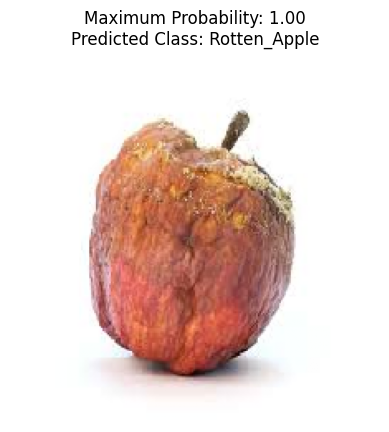

In [73]:
img, p, predicted_class = CNN_model_testing("C:/Users/alibh/OneDrive/Desktop/test/images.jpeg")
plot_model_testing(img, p, predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


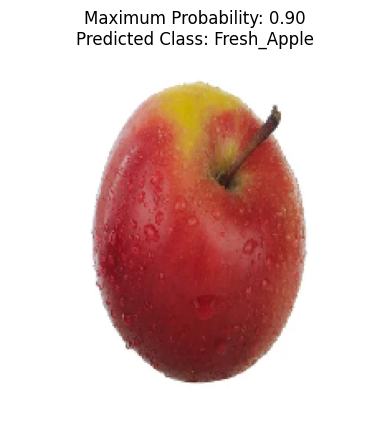

In [76]:
img, p, predicted_class = CNN_model_testing("C:/Users/alibh/OneDrive/Desktop/test/ab.jpg")
plot_model_testing(img, p, predicted_class)

In [2]:
##
from imageai.Detection import ObjectDetection
import os
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
from keras.models import load_model
from keras.preprocessing import image
import time

# Load your trained classification model
classification_model = load_model('C:/Users/alibh/OneDrive/Desktop/Enterprise_project/cnn_model.keras')

# Define the waste labels and create a reverse mapping
waste_labels = {"Fresh_Apple": 0, "Rotten_Apple": 1}
reverse_waste_labels = {v: k for k, v in waste_labels.items()}

# Function to preprocess images for TensorFlow model
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Set up ObjectDetection with YOLOv3
execution_path = os.getcwd()
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("C:/Users/alibh/OneDrive/Desktop/Enterprise_project/yolov3.pt")  # Replace with the actual path to your YOLOv3 model
detector.loadModel()

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_path = "C:/Users/alibh/OneDrive/Desktop/Enterprise_project/output.avi"
out = cv2.VideoWriter(output_path, fourcc, 20.0, (640, 480))

# Record for 120 seconds
start_time = time.time()
record_time = 120  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Save the current frame to disk for YOLOv3 detection
    frame_path = os.path.join(execution_path, "current_frame.jpg")
    if not cv2.imwrite(frame_path, frame):
        print("Error: Failed to write image to disk")
        continue

    # Perform object detection
    output_image_path = os.path.join(execution_path, "current_frame_output.jpg")
    detections = detector.detectObjectsFromImage(input_image=frame_path,
                                                 output_image_path=output_image_path,
                                                 minimum_percentage_probability=30)

    # Check if the output image exists and has a valid size
    if not os.path.exists(output_image_path):
        print(f"Error: {output_image_path} does not exist")
        continue
    
    if os.path.getsize(output_image_path) == 0:
        print(f"Error: {output_image_path} is empty")
        continue

    # Reload the frame with detections drawn
    img = cv2.imread(output_image_path)
    if img is None:
        print("Error: Failed to read image")
        continue

    for eachObject in detections:
        name = eachObject["name"]
        percentage_probability = eachObject["percentage_probability"]
        box_points = eachObject["box_points"]

        # Check if detected object is an apple
        if "apple" in name.lower():
            # Draw bounding box
            x1, y1, x2, y2 = box_points
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Extract region of interest (ROI) for TensorFlow model prediction
            roi = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).crop((x1, y1, x2, y2))
            roi_array = preprocess_image(roi)

            # Make predictions with TensorFlow model
            predictions = classification_model.predict(roi_array)
            predicted_class = np.argmax(predictions[0])

            # Draw label with predicted class
            cv2.putText(img, f"Class: {reverse_waste_labels[predicted_class]}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            print(f"{name} : {percentage_probability} : {box_points}")
            print(f"Predicted Class: {reverse_waste_labels[predicted_class]}")
            print("--------------------------------")

    # Write the frame with detections
    out.write(img)

    # Display the image with detections
    cv2.imshow('Object Detection', img)

    # Break the loop if 'q' key is pressed or 120 seconds have passed
    if cv2.waitKey(1) & 0xFF == ord('q') or (time.time() - start_time) > record_time:
        break

# Release the webcam and close all OpenCV windows
cap.release()
out.release()
cv2.destroyAllWindows()


In [1]:
import torch
import cv2
import numpy as np
from PIL import Image
from keras.models import load_model
from keras.preprocessing import image
import time

# Load your trained classification model
classification_model = load_model('C:/Users/alibh/OneDrive/Desktop/Enterprise_project/cnn_model.keras')

# Define the waste labels and create a reverse mapping
waste_labels = {"Fresh_Apple": 0, "Rotten_Apple": 1}
reverse_waste_labels = {v: k for k, v in waste_labels.items()}

# Function to preprocess images for TensorFlow model
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Function to preprocess images for YOLOv3-tiny
def preprocess_yolo_image(image, img_size):
    image = cv2.resize(image, img_size)
    image = image[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    image = np.ascontiguousarray(image, dtype=np.float32)  # uint8 to float32
    image /= 255.0  # 0 - 255 to 0.0 - 1.0
    return image

# Load the YOLOv3-tiny model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='C:/Users/alibh/OneDrive/Desktop/Enterprise_project/yolov3-tiny.pt')
model.eval()

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_path = "C:/Users/alibh/OneDrive/Desktop/Enterprise_project/output.avi"
out = cv2.VideoWriter(output_path, fourcc, 20.0, (640, 480))

# Record for 120 seconds
start_time = time.time()
record_time = 120  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Preprocess the image for YOLOv3-tiny
    img_size = (416, 416)
    image_yolo = preprocess_yolo_image(frame, img_size)

    # Convert image to tensor
    image_tensor = torch.from_numpy(image_yolo).unsqueeze(0)

    # Perform object detection
    with torch.no_grad():
        detections = model(image_tensor)[0]

    # Check if detections tensor is not empty
    if detections is not None and len(detections) > 0 and detections.ndim == 2:
        # Rescale boxes from img_size to frame size
        detections[:, :4] = detections[:, :4].round()

        for *xyxy, conf, cls in detections:
            x1, y1, x2, y2 = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])

            # Check if detected object is an apple
            label = f'{model.names[int(cls)]} {conf:.2f}'
            if "apple" in label.lower():
                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # Extract region of interest (ROI) for TensorFlow model prediction
                roi = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).crop((x1, y1, x2, y2))
                roi_array = preprocess_image(roi)

                # Make predictions with TensorFlow model
                predictions = classification_model.predict(roi_array)
                predicted_class = np.argmax(predictions[0])

                # Draw label with predicted class
                cv2.putText(frame, f"Class: {reverse_waste_labels[predicted_class]}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                print(f"Detected: {label}")
                print(f"Predicted Class: {reverse_waste_labels[predicted_class]}")
                print("--------------------------------")

    # Write the frame with detections
    out.write(frame)

    # Display the image with detections
    cv2.imshow('Object Detection', frame)

    # Break the loop if 'q' key is pressed or 120 seconds have passed
    if cv2.waitKey(1) & 0xFF == ord('q') or (time.time() - start_time) > record_time:
        break

# Release the webcam and close all OpenCV windows
cap.release()
out.release()
cv2.destroyAllWindows()


Using cache found in C:\Users\alibh/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-7-22 Python-3.12.4 torch-2.3.1+cpu CPU

Fusing layers... 
yolov3-tiny summary: 48 layers, 8849182 parameters, 0 gradients, 13.2 GFLOPs
Adding AutoShape... 


RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [5]:
##
from imageai.Detection import ObjectDetection
import os
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
from keras.models import load_model
from keras.preprocessing import image
import time

# Load your trained classification model
classification_model = load_model('C:/Users/alibh/OneDrive/Desktop/Enterprise_project/cnn_model.keras')

# Define the waste labels and create a reverse mapping
waste_labels = {"Fresh_Apple": 0, "Rotten_Apple": 1}
reverse_waste_labels = {v: k for k, v in waste_labels.items()}

# Function to preprocess images for TensorFlow model
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Set up ObjectDetection with YOLOv3
execution_path = os.getcwd()
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("C:/Users/alibh/OneDrive/Desktop/Enterprise_project/yolov3-tiny.pt")  # Replace with the actual path to your YOLOv3 model
detector.loadModel()

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_path = "C:/Users/alibh/OneDrive/Desktop/Enterprise_project/output.avi"
out = cv2.VideoWriter(output_path, fourcc, 20.0, (640, 480))

# Record for 120 seconds
start_time = time.time()
record_time = 120  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Save the current frame to disk for YOLOv3 detection
    frame_path = os.path.join(execution_path, "current_frame.jpg")
    if not cv2.imwrite(frame_path, frame):
        print("Error: Failed to write image to disk")
        continue

    # Perform object detection
    output_image_path = os.path.join(execution_path, "current_frame_output.jpg")
    detections = detector.detectObjectsFromImage(input_image=frame_path,
                                                 output_image_path=output_image_path,
                                                 minimum_percentage_probability=30)

    # Check if the output image exists and has a valid size
    if not os.path.exists(output_image_path):
        print(f"Error: {output_image_path} does not exist")
        continue
    
    if os.path.getsize(output_image_path) == 0:
        print(f"Error: {output_image_path} is empty")
        continue

    # Reload the frame with detections drawn
    img = cv2.imread(output_image_path)
    if img is None:
        print("Error: Failed to read image")
        continue

    for eachObject in detections:
        name = eachObject["name"]
        percentage_probability = eachObject["percentage_probability"]
        box_points = eachObject["box_points"]

        # Check if detected object is an apple
        if "apple" in name.lower():
            # Draw bounding box
            x1, y1, x2, y2 = box_points
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Extract region of interest (ROI) for TensorFlow model prediction
            roi = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).crop((x1, y1, x2, y2))
            roi_array = preprocess_image(roi)

            # Make predictions with TensorFlow model
            predictions = classification_model.predict(roi_array)
            predicted_class = np.argmax(predictions[0])

            # Draw label with predicted class
            cv2.putText(img, f"Class: {reverse_waste_labels[predicted_class]}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            print(f"{name} : {percentage_probability} : {box_points}")
            print(f"Predicted Class: {reverse_waste_labels[predicted_class]}")
            print("--------------------------------")

    # Write the frame with detections
    out.write(img)

    # Display the image with detections
    cv2.imshow('Object Detection', img)

    # Break the loop if 'q' key is pressed or 120 seconds have passed
    if cv2.waitKey(1) & 0xFF == ord('q') or (time.time() - start_time) > record_time:
        break

# Release the webcam and close all OpenCV windows
cap.release()
out.release()
cv2.destroyAllWindows()


RuntimeError: Invalid weights!!!